In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
# Add inspect
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Take a look at info; names and types for hawaii_measurements
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Take a look at info; names and types for hawaii_stations
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# find last measure date, turn date to value, and then query last 12 months from date (if 2017-08-23 is last date recorded
# then we will use 2016-08-22 to get a full year of records)
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()



('2017-08-23')

In [47]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
#filter by last year of precip data
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()
#precip_data

# Sort the dataframe by date
# Plot the Results in a Matplotlib bar chart
df = pd.DataFrame(precip_data, columns=['date', 'precip'])
#df.set_index('date', inplace=True)

# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


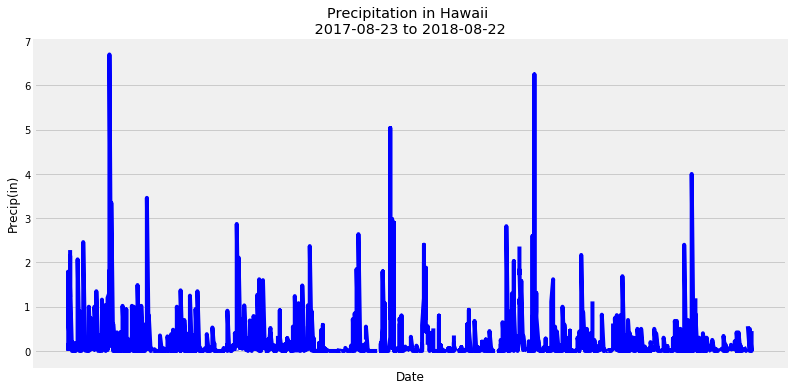

In [48]:
# Use Pandas Plotting with Matplotlib to plot the data

# Create the plot space upon which to plot the data
fig, ax = plt.subplots(figsize=(12, 6))

# Add the x-axis and the y-axis to the plot
ax.plot(df['date'],df['precip'],
        color='blue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precip(in)",
       title="Precipitation in Hawaii \n 2017-08-23 to 2018-08-22 ")

# Clean up the x axis dates 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=15))
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))

plt.show()
fig.savefig('hawaii_precip.png')

In [68]:
# Design a query to show how many stations are available in this dataset?
# List the stations and the counts in descending order.
station_data = session.query(func.count(Measurement.date), Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
station_data

# What are the most active stations? (i.e. what stations have the most rows)?
# WAIHEE 837.5, HI US has the most rows with 2772

[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# verify station by looking at CSV
station_Honolulu = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)\
    , Measurement.station).\
    filter(Measurement.station == 'USC00519281').all()

station_Honolulu

[(54.0, 85.0, 71.66378066378067, 'USC00519281')]

In [73]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# USC00519281
session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()
# results ('2017-08-18', 'USC00519281', 79.0)

Honolulu_temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > '2016-08-17').\
    order_by(Measurement.date).all()
# Honolulu_temp_data

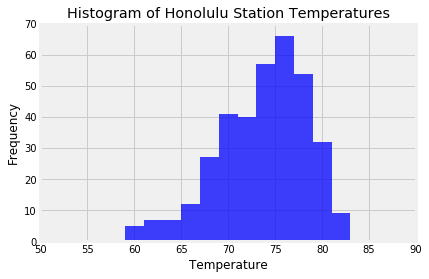

In [75]:
# Plot results in a Matplotlib bar chart
df = pd.DataFrame(Honolulu_temp_data, columns=['date','tobs'])
#df.set_index('date', inplace=True)

a = np.array(df)
x = a[0:,1]

n, bins, patches = plt.hist(x, 12, facecolor='b', alpha=0.75)

# Create histogram
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Honolulu Station Temperatures')

plt.xlim(50, 90)
plt.ylim(0, 70)
plt.grid(True)
plt.show()
fig.savefig('Honolulu_hist.png')

In [76]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [77]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-08-17', '2017-08-16'))


[(58.0, 74.59946476360392, 87.0)]


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
